Given a subset of DNA and the codon elongation rate data, calculate the time (in seconds) the subset will take to be translated.

In [19]:
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent))

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from lib.calculations import run_elongation_time_analysis
from lib.genetic_data_helpers import *
from lib.data_access_helpers import load_fasta_records

In [20]:

############### First get list of SRP dependent and independent genes from the secretome ################

path = '../data/dependent_hydrophobic_genes.csv'
srp_dep = pd.read_csv(path)

indep_path = "../data/independent_hydrophobic_genes.csv"
srp_indep = pd.read_csv(indep_path)

print(f"SRP dependent shape: {srp_dep.shape}")
print(f"SRP independent shape: {srp_indep.shape}")



SRP dependent shape: (344, 6)
SRP independent shape: (299, 6)


In [21]:
########### Load the DNA fasta for the genes ##########
path = "../data/dep_dna_filtered.fasta"
srp_dep_records = load_fasta_records(path)

indep_path = "../data/indep_dna_filtered.fasta"
indep_records = load_fasta_records(indep_path)
    

In [24]:
###########
w = 30
d = 35

window_size = w * 3
distance = d * 3

dep_times = []
genes = []
for record in srp_dep_records:
    gene = record.id
    row = srp_dep[srp_dep['gene'] == gene]
    # get the coordinate of the first hydrophobic region's end (in nucleotides)
    hydro_end_n = int(row['first_hydrophobic_end'].iloc[0]) * 3
    
    time = run_elongation_time_analysis(record, window_size, distance, hydro_end_n)
    if time != 0.0:
        dep_times.append(time)
        genes.append(gene)
dep_df = pd.DataFrame({
    'gene': genes,
    'time': dep_times
})
dep_df.to_csv("../data/times/dep_times.csv")
    
dep_times_arr = np.array(dep_times)

indep_times = []
genes = []
for record in indep_records:
    gene = record.id
    row = srp_indep[srp_indep['gene'] == gene]
    # get the coordinate of the first hydrophobic region's end
    hydro_end_n = int(row['first_hydrophobic_end'].iloc[0]) * 3
    
    time = run_elongation_time_analysis(record, window_size, distance, hydro_end_n)
    if time != 0.0:
        indep_times.append(time)
        genes.append(gene)
indep_times_arr = np.array(indep_times)

indep_df = pd.DataFrame({
    'gene': genes,
    'time': indep_times
})
indep_df.to_csv("../data/times/indep_times.csv")

Sequence YDR525W-A too short for window choice.
Sequence YIL102C-A too short for window choice.
Sequence YOR103C too short for window choice.
Sequence YCL048W-A too short for window choice.


SRP-dependent Statistics:
  Count: 341
  Mean: 4.408
  Std: 0.402
  Median: 4.373

SRP-independent Statistics:
  Count: 298
  Mean: 4.210
  Std: 0.427
  Median: 4.190

T-test Result:
    Statistic: 6.011049646682758
    P-value: 3.1037297511570833e-09


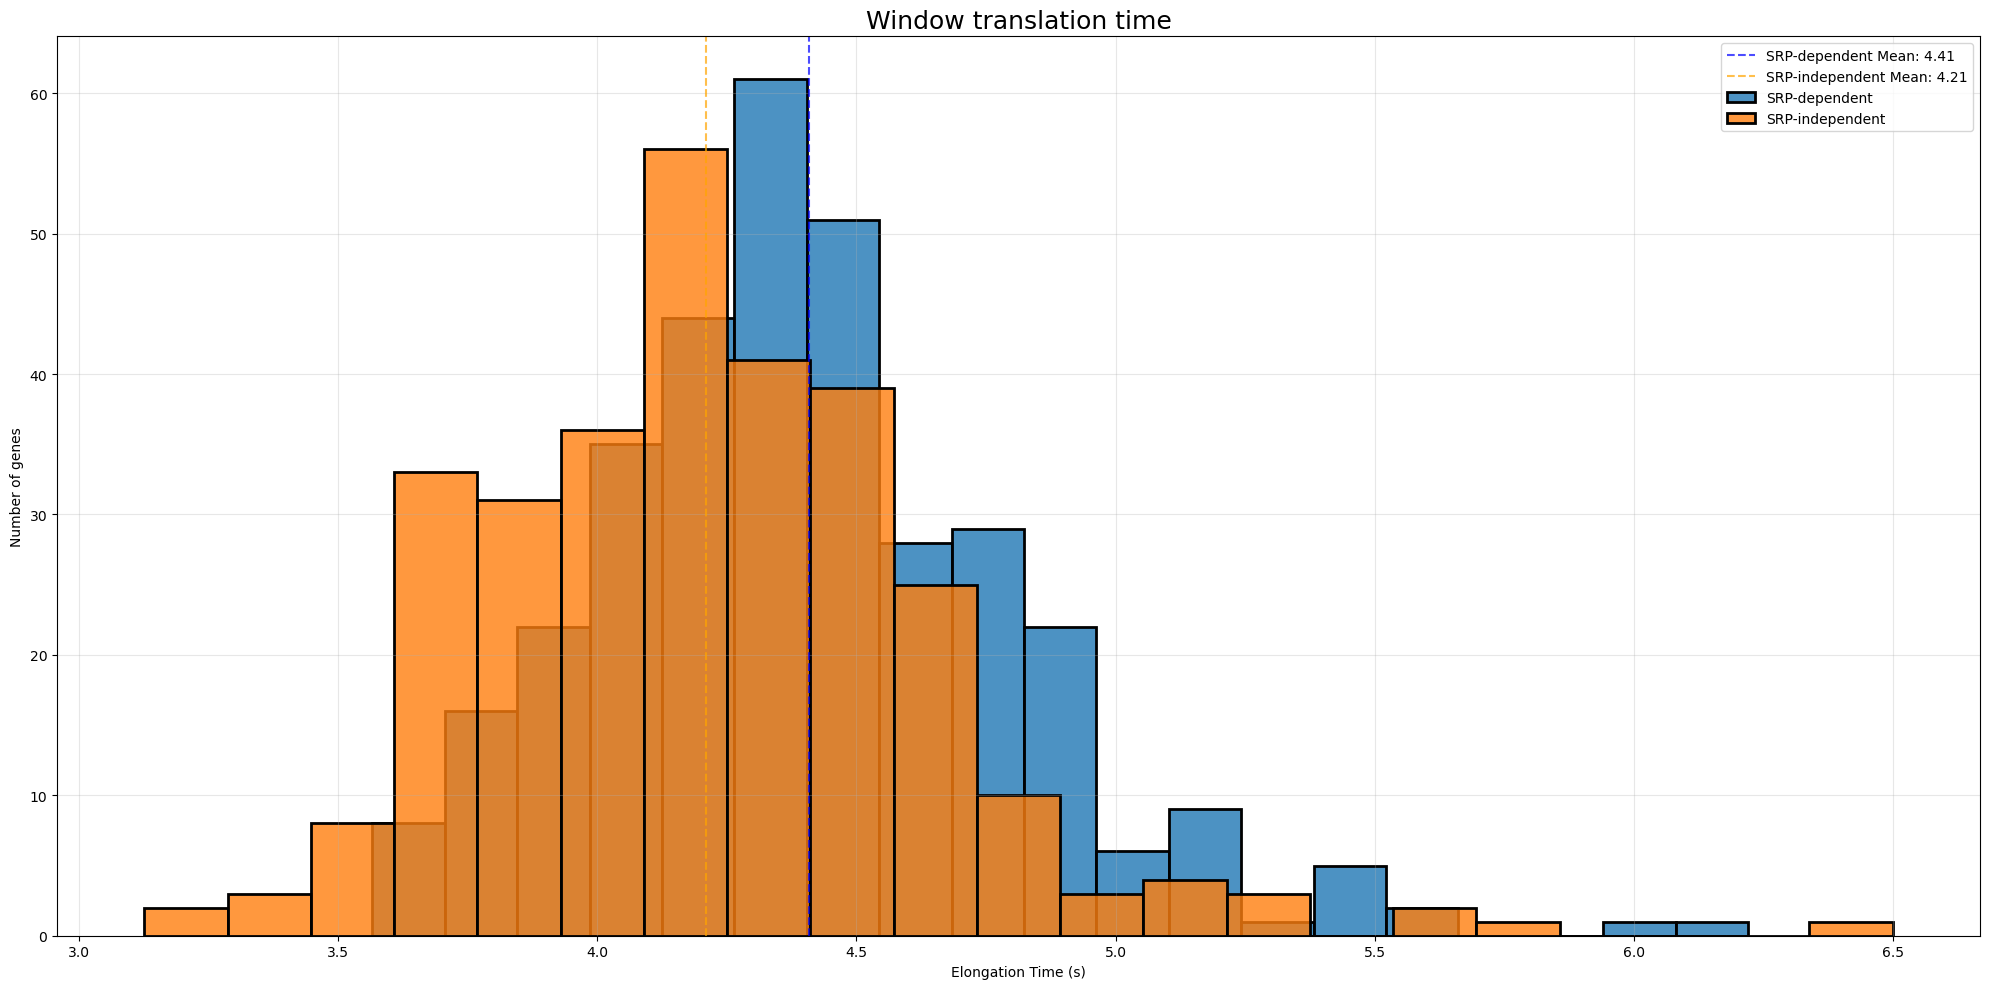

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))

# Create KDE plots
sns.histplot(dep_times_arr, label="SRP-dependent", linewidth=2, alpha=0.8)
sns.histplot(indep_times_arr, label="SRP-independent", linewidth=2, alpha=0.8)

# Add vertical lines for means
mean1 = np.mean(dep_times_arr)
mean2 = np.mean(indep_times_arr)
plt.axvline(mean1, color='blue', linestyle='--', alpha=0.7, label=f'SRP-dependent Mean: {mean1:.2f}')
plt.axvline(mean2, color='orange', linestyle='--', alpha=0.7, label=f'SRP-independent Mean: {mean2:.2f}')

# Customize the plot
plt.xlabel('Elongation Time (s)')
plt.ylabel('Number of genes')
plt.title(f'Window translation time', fontsize=18)
plt.legend()
plt.grid(True, alpha=0.3)

# Print summary statistics
print(f"SRP-dependent Statistics:")
print(f"  Count: {len(dep_times_arr)}")
print(f"  Mean: {mean1:.3f}")
print(f"  Std: {np.std(dep_times_arr):.3f}")
print(f"  Median: {np.median(dep_times_arr):.3f}")

print(f"\nSRP-independent Statistics:")
print(f"  Count: {len(indep_times_arr)}")
print(f"  Mean: {mean2:.3f}")
print(f"  Std: {np.std(indep_times_arr):.3f}")
print(f"  Median: {np.median(indep_times_arr):.3f}")

result = ttest_ind(dep_times_arr, indep_times_arr)
print("\nT-test Result:")
print(f"    Statistic: {result.statistic}")
print(f"    P-value: {result.pvalue}")

plt.tight_layout()
plt.show()